# Finding optimal number of data encoding repetitions

As already mentioned the best fit for this algorithm is for the time series task. 
But also for image data, where the spatial correlations are important, this algorithm can be used.
For tabular data this is not the best fit, because the target function is probably not smooth (similar to timeseries with alot of noise). The model only needs to understand how the independent features relate to the target label

Note that with image data for example you should approximate the decision boundary and not the target value. Quantum Kernel methods invest alot of work making the decision boundary easier to approximate.

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import pandas as pd

In [63]:
stock_data = pd.read_csv('./data/indexData.csv')  
nasdaq_data = stock_data[stock_data['Index'] == 'IXIC']
close_prices = nasdaq_data['Close'].values  
hi = nasdaq_data['High'].values
lo = nasdaq_data['Low'].values
volume = nasdaq_data['Volume'].values
avg = (hi + lo) / 2
x = np.arange(len(close_prices)) 

In [64]:
def serial_1_qubit_n_repetitions_model(n): # data reuploading
    # no that the feautre map and ansatz included in the model qc
    qc = QuantumCircuit(1)
 
    # data encoding block
    def S(label, id):
        param_x = Parameter(f"{label}_{id}") 
        qc.h(0)
        qc.rx(param_x, 0)
        qc.h(0)

    # trainable variational block
    def W(label, id):
        param_w_0 = Parameter(f"{label}_{id}_0") 
        param_w_1 = Parameter(f"{label}_{id}_1")
        param_w_2 = Parameter(f"{label}_{id}_2")
        qc.u(param_w_0, param_w_1, param_w_2, 0)

    unique_id = 0
    for _ in range(n):
        S('X', unique_id)
        W('W', unique_id)       
        unique_id += 1           

    #W('W', unique_id)

    return qc

# serial encoding
qc_serial = serial_1_qubit_n_repetitions_model(3)

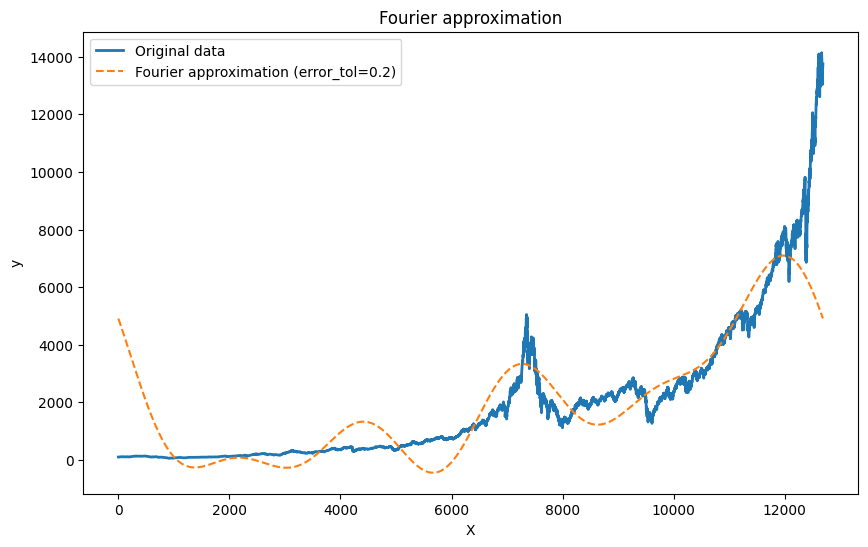

Atleast 3 repetitions are needed
Upperbound: 31.0 possible frequencies represented


In [65]:
def time_series_lowerbound_data_encoding_repetitions(data_set, encoding='linear', error_tol=0.1, print_output=True, target_function_degree=-1):
    repetitions = -1
    X, y = data_set

    # Fourier transform
    fourier = np.fft.fft(y) # maybe downsample the data first
    magnitude = np.abs(fourier)

    normalized_magnitude = magnitude / np.max(magnitude)
    mask = normalized_magnitude > error_tol
    fourier_rank = np.sum(mask) # number of non-zero coefficients
    filtered_fourier = fourier * mask
    fourier_approx = np.fft.ifft(filtered_fourier)
    degree = np.sum(mask) # just approximately

    if print_output:
        plt.figure(figsize=(10, 6))
        plt.plot(X, y, label='Original data', linewidth=2)
        plt.plot(X, fourier_approx.real, label=f'Fourier approximation (error_tol={error_tol})', linestyle='--')
        plt.legend()
        plt.title('Fourier approximation')
        plt.xlabel('X')
        plt.ylabel('y')
        plt.show()

    if encoding == 'linear':
        repetitions = np.log(2 * fourier_rank + 1) / np.log(3)
    elif encoding == 'arcsine' or encoding == 'polynomial':
        # could also be calculated by sc-rank
        if target_function_degree != -1: degree = target_function_degree 
        repetitions = degree
    else:
        print("Invalid encoding type. Please choose 'linear', 'polynomial' or 'arcsine' encoding.")
    
    return int(np.ceil(repetitions))

def time_series_upperbound(qc, reps):
    d = 2**qc.num_qubits
    L = reps

    return d ** (2 * L) / 2 - 1


"""
Note that it calculates the lowerbound regarding an error tolerance.
So it could also be used for optimal repetitions for a given tolerance.
"""
reps = time_series_lowerbound_data_encoding_repetitions((x, close_prices), error_tol=0.2)
print(f"Atleast {reps} repetitions are needed")
print(f"Upperbound: {time_series_upperbound(qc_serial, reps)} possible frequencies represented")

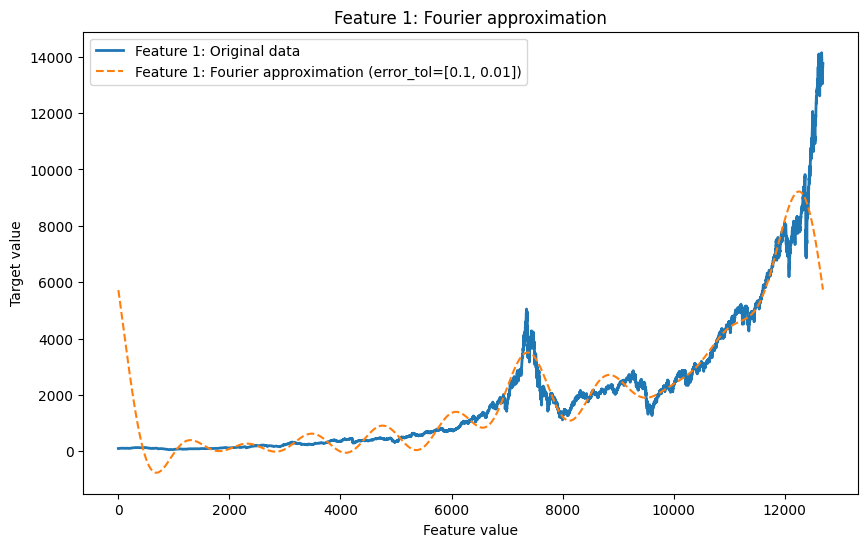

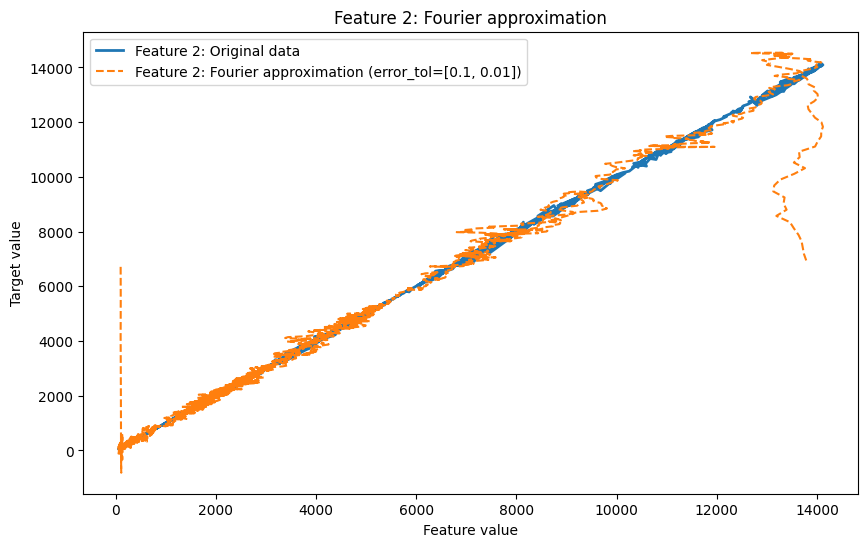

Repetitions per feature: {'Feature 1': 19, 'Feature 2': 209}
Highest repetition needed:  209


In [66]:
def time_series_lowerbound_data_encoding_repetitions_multi_dim(data_set, encoding='linear', error_tol=[0.1], print_output=True, target_function_degree=-1):
    X, y = data_set
    rep_dict = {}

    # Fourier transform (getting the freq components)
    fourier = np.fft.fft(y) # maybe downsample the data first
    magnitude = np.abs(fourier)

    normalized_magnitude = magnitude / np.max(magnitude)

    for feature in range(len(X)):
        feature_name = f'Feature {feature + 1}'
        feature_data = X[feature]

        mask = normalized_magnitude > error_tol[feature]
        fourier_rank = np.sum(mask) # number of non-zero coefficients
        filtered_fourier = fourier * mask
        fourier_approx = np.fft.ifft(filtered_fourier)
        degree = np.sum(mask) # just approximately

        if print_output:
            plt.figure(figsize=(10, 6))
            plt.plot(feature_data, y, label=f'{feature_name}: Original data', linewidth=2)
            plt.plot(feature_data, fourier_approx.real, label=f'{feature_name}: Fourier approximation (error_tol={error_tol})', linestyle='--')
            plt.legend()
            plt.title(f'{feature_name}: Fourier approximation')
            plt.xlabel('Feature value')
            plt.ylabel('Target value')
            plt.show()

        if encoding == 'linear':
            repetitions = np.log(2 * fourier_rank + 1) / np.log(3)
        elif encoding == 'arcsine' or encoding == 'polynomial':
            if target_function_degree != -1:
                degree = target_function_degree
            repetitions = degree
        else:
            raise ValueError("Invalid encoding type. Choose 'linear', 'polynomial' or 'arcsine'.")

        rep_dict[feature_name] = int(np.ceil(repetitions))

    return rep_dict
reps_dict = time_series_lowerbound_data_encoding_repetitions_multi_dim(([x, avg], close_prices), encoding='arcsine', error_tol=[0.1, 0.01]) # note: tol per feature
print(f"Repetitions per feature: {reps_dict}")
print("Highest repetition needed: ", max(reps_dict.values()))